In [91]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
%matplotlib inline
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import xgboost
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,SpatialDropout1D
from tensorflow.keras.layers import LSTM,Dropout
from keras.layers import Bidirectional
from tensorflow.keras.optimizers import RMSprop,Adam

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv
/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv


In [3]:
train=pd.read_csv("/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv")
test=pd.read_csv("/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv")

In [4]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [6]:
def drop(te):
    te.drop("id",axis=1,inplace=True)

In [7]:
drop(train)

In [8]:
drop(test)

In [9]:
train.isnull().any()

label    False
tweet    False
dtype: bool

Lets check if their is any null value

In [10]:
test.isnull().any()

tweet    False
dtype: bool

In [11]:
train["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

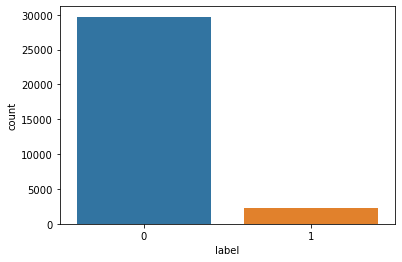

In [12]:
sns.countplot("label",data=train)

Data is imbalanced we will balanced it later before sending it to our Model

# DATA PREPROCESSING

lEt initiliaze our stemmer and tokenizer and do some data processing

In [13]:
tweettoken = TweetTokenizer(strip_handles=True, reduce_len=True)

In [14]:
stemmer=PorterStemmer()

In [15]:
collect=[]
collecttest=[]
def preprocess(t,kpc):
    tee=re.sub('[^a-zA-Z]'," ",t)
    tee=tee.lower()
    res=tweettoken.tokenize(tee)
    for i in res:
        if i in stopwords.words('english'):
            res.remove(i)
    rest=[]
    for k in res:
        rest.append(stemmer.stem(k))
    ret=" ".join(rest)
    if kpc==1:
        collect.append(ret)
    elif kpc==0:
        collecttest.append(ret)

In [16]:
def splitpro(t,q,m):
         for j in range(q):
                 preprocess(t["tweet"].iloc[j],m)

In [17]:
splitpro(train,31962,1)

In [24]:
splitpro(test,17197,0)

In [25]:
len(collect)

31962

In [26]:
len(collecttest)

17197

In [27]:
len(test)

17197

In [28]:
collect[:5]

['user a father dysfunct is selfish drag kid hi dysfunct run',
 'user user thank lyft credit can use caus don offer wheelchair van pdx disapoint getthank',
 'bihday majesti',
 'model love u take u the time ur',
 'factsguid societi motiv']

In [29]:
collecttest[:5]

['studiolif aislif requir passion dedic willpow find newmateri',
 'user white supremacist want everyon see new bird movi here whi',
 'safe way heal acn altwaystoh healthi heal',
 'the hp the curs child book for reserv alreadi ye if when harrypott pottermor favorit',
 'rd bihday my amaz hilari nephew eli ahmir uncl dave love and miss']

In [30]:
val=train["label"].values

In [31]:
val

array([0, 0, 0, ..., 0, 1, 0])

# DATA BALANCING AND GOING FORWARD WITH ML ALGORITHMS

In [98]:
def bow(ll):
    cv=CountVectorizer(max_features=200)
    x=cv.fit_transform(ll).toarray()
    return x
    

In [99]:
y=bow(collect)

In [100]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0])

In [101]:
len(y[0][:])

200

Balancing imbalanced dataset

In [102]:
from imblearn.under_sampling import NearMiss

In [103]:
tt=NearMiss()
x_us,y_us=tt.fit_sample(y,val)

In [104]:
x_us.shape

(4484, 200)

In [105]:
(x_train,x_test,y_train,y_test) = train_test_split(x_us,y_us, train_size=0.80, random_state=42)

In [106]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [107]:
rnd_clf=RandomForestClassifier(n_estimators=200,random_state=42)

In [108]:
rnd_clf.fit(x_train,y_train)

RandomForestClassifier(n_estimators=200, random_state=42)

In [109]:
rnd_clf.score(x_test,y_test)

0.8461538461538461

In [110]:
mm=[300,400,500,600]
for i in mm:
    rnd_clf=RandomForestClassifier(n_estimators=i,random_state=42)
    rnd_clf.fit(x_train,y_train)
    t=rnd_clf.score(x_test,y_test)
    print(t)
    print("*"*40)

0.8472686733556298
****************************************
0.8461538461538461
****************************************
0.8461538461538461
****************************************
0.8472686733556298
****************************************


In [111]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(x_train,y_train)
clf.score(x_train,y_train)

0.8118204627822693

In [112]:
params={
    "eta":[0.01,0.2],
    "min_child_weight":[1,2,3,4,5,6,7,8,9,10],
    "max_depth":[3,6,8,10,15,20,25,30],
    "gamma":[0.0,0.1,0.2,0.3,0.4,0.5,0.6],
    "subsample":[0.5,0.6,0.7,0.8,0.9],
    "colsample_bytree":[0.6,0.7,0.8,0.8],
    "reg_alpha":[0,0.001,0.005,0.01,0.05],
    "learning_rate":[0.05,0.10,0.15,0.20,0.25,0.30],
    "max_leaf_nodes":[8,16,24,32,40],
}

In [113]:
from sklearn.model_selection import RandomizedSearchCV

In [114]:
classifier=xgboost.XGBClassifier()

In [115]:
random=RandomizedSearchCV(classifier,param_distributions=params,n_iter=5,scoring="roc_auc",cv=5,verbose=3)

In [116]:
random.fit(x_train,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] subsample=0.5, reg_alpha=0.005, min_child_weight=6, max_leaf_nodes=16, max_depth=10, learning_rate=0.1, gamma=0.0, eta=0.2, colsample_bytree=0.7 
[19:10:30] WARNING: ../src/learner.cc:516: 
Parameters: { max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.5, reg_alpha=0.005, min_child_weight=6, max_leaf_nodes=16, max_depth=10, learning_rate=0.1, gamma=0.0, eta=0.2, colsample_bytree=0.7, score=0.775, total=   1.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV] subsample=0.5, reg_alpha=0.005, min_child_weight=6, max_leaf_nodes=16, max_depth=10, learning_rate=0.1, gamma=0.0, eta=0.2, colsample_bytree=0.7 
[19:10:32] WARNING: ../src/learner.cc:516: 
Parameters: { max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.5, reg_alpha=0.005, min_child_weight=6, max_leaf_nodes=16, max_depth=10, learning_rate=0.1, gamma=0.0, eta=0.2, colsample_bytree=0.7, score=0.782, total=   1.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV] subsample=0.5, reg_alpha=0.005, min_child_weight=6, max_leaf_nodes=16, max_depth=10, learning_rate=0.1, gamma=0.0, eta=0.2, colsample_bytree=0.7 
[19:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.5, reg_alpha=0.005, min_child_weight=6, max_leaf_nodes=16, max_depth=10, learning_rate=0.1, gamma=0.0, eta=0.2, colsample_bytree=0.7, score=0.781, total=   1.6s
[CV] subsample=0.5, reg_alpha=0.005, min_child_weight=6, max_leaf_nodes=16, max_depth=10, learning_rate=0.1, gamma=0.0, eta=0.2, colsample_bytree=0.7 
[19:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
 


[CV]  subsample=0.8, reg_alpha=0, min_child_weight=5, max_leaf_nodes=16, max_depth=20, learning_rate=0.3, gamma=0.2, eta=0.2, colsample_bytree=0.8, score=0.811, total=   2.9s
[CV] subsample=0.9, reg_alpha=0.005, min_child_weight=2, max_leaf_nodes=40, max_depth=25, learning_rate=0.2, gamma=0.3, eta=0.01, colsample_bytree=0.7 
[19:11:08] WARNING: ../src/learner.cc:516: 
Parameters: { max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV]  subsample=0.9, reg_alpha=0.005, min_child_weight=2, max_leaf_nodes=40, max_depth=25, learning_rate=0.2, gamma=0.3, eta=0.01, colsample_bytree=0.7, score=0.865, total=   4.5s
[CV] subsample=0.9, reg_alpha=0.005, min_child_weight=2, max_leaf_nodes=40, max_depth=25, learning_rate=0.2, gamma=0.3, eta=0.01, colsample_bytree=0.7 
[19:11

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:  1.2min finished


[19:11:40] WARNING: ../src/learner.cc:516: 
Parameters: { max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                   param_distributions={'colsample_bytree': [0.6, 0.7, 0.8,
                                                             0.8],
                                      

In [117]:
random.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, eta=0.01, gamma=0.3,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=25,
              max_leaf_nodes=40, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0.005,
              reg_lambda=1, scale_pos_weight=1, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [118]:
classifier=xgboost.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eta=0.01, gamma=0.1,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=25,
              max_leaf_nodes=40, min_child_weight=1,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, random_state=0, reg_alpha=0.05, reg_lambda=1,
              scale_pos_weight=1, subsample=0.6, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [119]:
classifier.fit(x_train,y_train)
classifier.score(x_test,y_test)

[19:11:57] WARNING: ../src/learner.cc:516: 
Parameters: { max_leaf_nodes } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.8405797101449275

In [127]:
from sklearn import svm
C = [1,10,20,25,30,35,40,50]

In [124]:
for i in C:
    svc = svm.SVC(kernel='linear', C=i)
    svc.fit(x_train,y_train)
    t=svc.score(x_test,y_test)
    print(t)

0.8472686733556298
0.8517279821627648
0.8517279821627648
0.8517279821627648
0.8517279821627648
0.850613154960981
0.8517279821627648
0.850613154960981


In [128]:
for i in C:
    svc = svm.SVC(kernel='rbf', C=i)
    svc.fit(x_train,y_train)
    t=svc.score(x_test,y_test)
    print(t)

0.8862876254180602
0.8896321070234113
0.8896321070234113
0.8896321070234113
0.8896321070234113
0.8896321070234113
0.8896321070234113
0.8896321070234113


# GOING FORWARD WITH KERAS

In [35]:
oneh=[]
oneht=[]
def hot(cc,k):
    for i in cc:
        if k==1:
            oneh.append(one_hot(i,10000))
        elif k==0:
            oneht.append(one_hot(i,10000))

In [37]:
hot(collect,1)

In [38]:
hot(collecttest,0)

In [45]:
len(oneh[0])

11

In [42]:
oneh[:1]

[[9015, 2622, 3582, 6329, 8953, 2106, 6605, 648, 8964, 6329, 2744]]

In [43]:
len(oneh)

31962

In [44]:
len(oneht)

17197

In [48]:
max=0
for i in oneh:
    tq=len(i)
    if tq>max:
        max=tq
print(max)

38


In [50]:
sent=40
emoneh=pad_sequences(oneh,padding="pre",maxlen=sent)
emoneht=pad_sequences(oneht,padding="pre",maxlen=sent)

In [54]:
emoneh[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0, 9015, 2622, 3582, 6329,
        8953, 2106, 6605,  648, 8964, 6329, 2744]], dtype=int32)

In [55]:
emoneht[:1]

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0, 3059,
        8144, 3092, 6934, 1806, 2235,   92, 2392]], dtype=int32)

In [62]:
xtrain,xtest,ytrain,ytest=train_test_split(emoneh,val,train_size=0.80,random_state=42)

In [92]:
model=Sequential()
model.add(Embedding(10000,100,input_length=sent))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(100))
model.add(Dropout(0.1))
model.add(Dense(1, activation='softmax'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [93]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 40, 100)           1000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 100)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 1,080,501
Trainable params: 1,080,501
Non-trainable params: 0
_________________________________________________________________


In [94]:
model.fit(xtrain,ytrain,validation_data=(xtest,ytest),epochs=50,batch_size=300,verbose=2)

Epoch 1/50
86/86 - 2s - loss: 14.1841 - accuracy: 0.0699 - val_loss: 14.1615 - val_accuracy: 0.0713
Epoch 2/50
86/86 - 1s - loss: 14.1841 - accuracy: 0.0699 - val_loss: 14.1615 - val_accuracy: 0.0713
Epoch 3/50
86/86 - 1s - loss: 14.1841 - accuracy: 0.0699 - val_loss: 14.1615 - val_accuracy: 0.0713
Epoch 4/50
86/86 - 1s - loss: 14.1841 - accuracy: 0.0699 - val_loss: 14.1615 - val_accuracy: 0.0713
Epoch 5/50
86/86 - 2s - loss: 14.1841 - accuracy: 0.0699 - val_loss: 14.1615 - val_accuracy: 0.0713
Epoch 6/50
86/86 - 1s - loss: 14.1841 - accuracy: 0.0699 - val_loss: 14.1615 - val_accuracy: 0.0713
Epoch 7/50
86/86 - 1s - loss: 14.1841 - accuracy: 0.0699 - val_loss: 14.1615 - val_accuracy: 0.0713
Epoch 8/50
86/86 - 1s - loss: 14.1841 - accuracy: 0.0699 - val_loss: 14.1615 - val_accuracy: 0.0713
Epoch 9/50
86/86 - 1s - loss: 14.1841 - accuracy: 0.0699 - val_loss: 14.1615 - val_accuracy: 0.0713
Epoch 10/50
86/86 - 1s - loss: 14.1841 - accuracy: 0.0699 - val_loss: 14.1615 - val_accuracy: 0.0713

In [95]:
ytest

array([0, 0, 0, ..., 0, 0, 1])

In [96]:
val

array([0, 0, 0, ..., 0, 1, 0])

In [97]:
model.predict(emoneht)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)